# Imports and parameters

In [251]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi
from skimage.draw import polygon
from PIL import Image
from noise import snoise3

In [252]:
size = 1024
n = 256
map_seed = 762345

In [253]:
np.random.seed(map_seed)

# Voronoi diagram

In [254]:
def voronoi(points, size):
    # Add points at edges to eliminate infinite ridges
    edge_points = size*np.array([[-1, -1], [-1, 2], [2, -1], [2, 2]])
    new_points = np.vstack([points, edge_points])
    
    # Calculate Voronoi tessellation
    vor = Voronoi(new_points)
    
    return vor

def voronoi_map(vor, size):
    # Calculate Voronoi map
    vor_map = np.zeros((size, size), dtype=np.uint32)

    for i, region in enumerate(vor.regions):
        # Skip empty regions and infinte ridge regions
        if len(region) == 0 or -1 in region: continue
        # Get polygon vertices    
        x, y = np.array([vor.vertices[i][::-1] for i in region]).T
        # Get pixels inside polygon
        rr, cc = polygon(x, y)
        # Remove pixels out of image bounds
        in_box = np.where((0 <= rr) & (rr < size) & (0 <= cc) & (cc < size))
        rr, cc = rr[in_box], cc[in_box]
        # Paint image
        vor_map[rr, cc] = i

    return vor_map

In [255]:
points = np.random.randint(0, size, (514, 2))
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

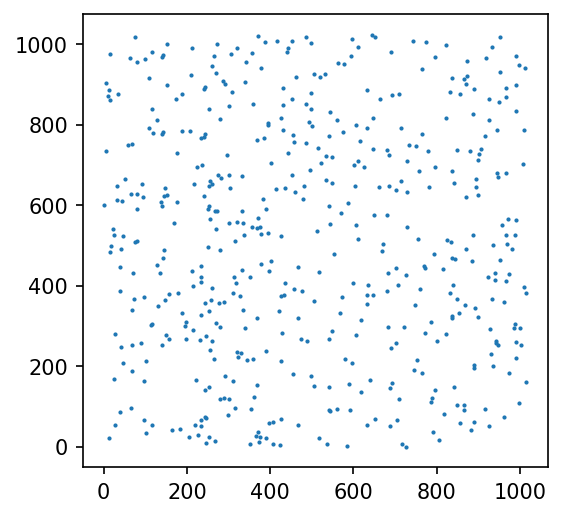

In [256]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

# Lloyd's relaxation

In [257]:
def relax(points, size, k=10):  
    new_points = points.copy()
    for _ in range(k):
        vor = voronoi(new_points, size)
        new_points = []
        for i, region in enumerate(vor.regions):
            if len(region) == 0 or -1 in region: continue
            poly = np.array([vor.vertices[i] for i in region])
            center = poly.mean(axis=0)
            new_points.append(center)
        new_points = np.array(new_points).clip(0, size)
    return new_points

In [258]:
points = relax(points, size, k=100)
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

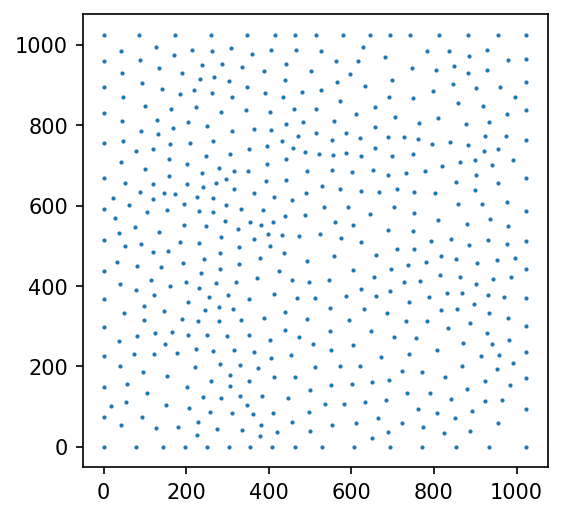

In [259]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

# Perlin noise / Simplex noise

In [260]:
def noise_map(size, res, seed, octaves=1, persistence=0.5, lacunarity=2.0):
    scale = size/res
    return np.array([[
        snoise3(
            (x+0.1)/scale,
            y/scale,
            seed+map_seed,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity
        )
        for x in range(size)]
        for y in range(size)
    ])

# Bluring the boundaries

In [261]:
boundary_displacement = 8
boundary_noise = np.dstack([noise_map(size, 32, 200, octaves=8), noise_map(size, 32, 250, octaves=8)])
boundary_noise = np.indices((size, size)).T + boundary_displacement*boundary_noise
boundary_noise = boundary_noise.clip(0, size-1).astype(np.uint32)

blurred_vor_map = np.zeros_like(vor_map)

for x in range(size):
    for y in range(size):
        j, i = boundary_noise[x, y]
        blurred_vor_map[x, y] = vor_map[i, j]

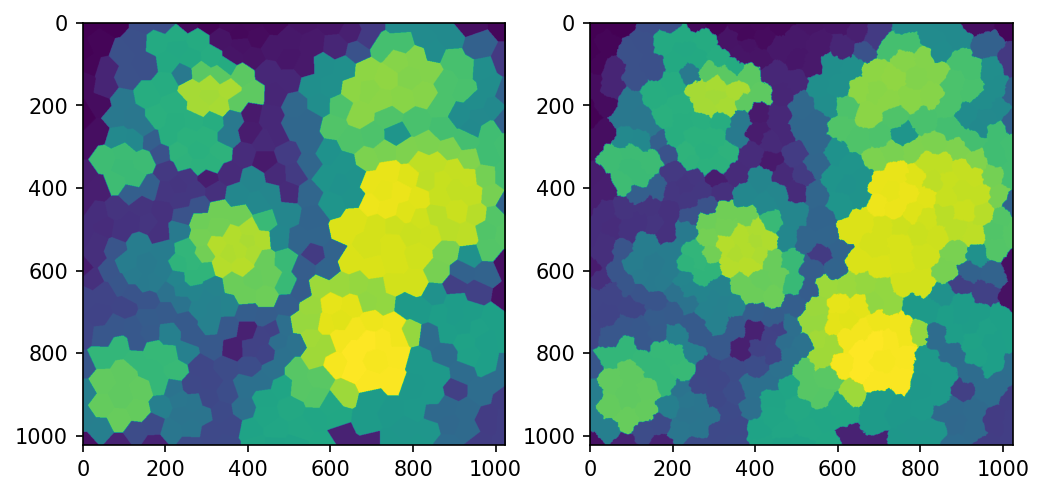

In [262]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)
axes[0].imshow(vor_map)
axes[1].imshow(blurred_vor_map)

In [263]:
vor_map = blurred_vor_map

# Choosing Biomes

## Temperature–Precipitation maps

In [264]:
temperature_map = noise_map(size, 2, 10)
precipitation_map = noise_map(size, 2, 20)

Text(0.5, 1.0, 'Precipitation Map')

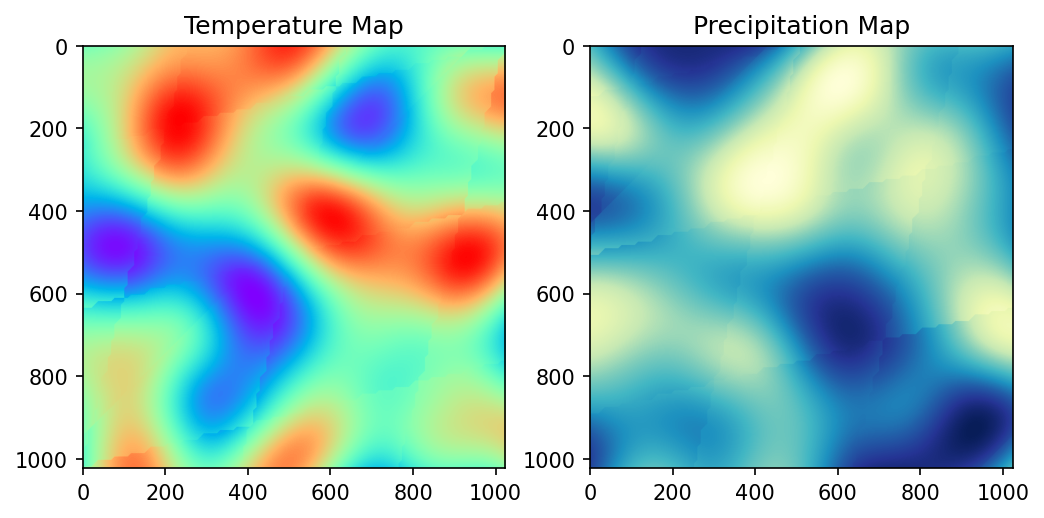

In [265]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].imshow(temperature_map, cmap="rainbow")
axes[0].set_title("Temperature Map")

axes[1].imshow(precipitation_map, cmap="YlGnBu")
axes[1].set_title("Precipitation Map")

## Histogram Equalization

[Text(0, 0, '1'),
 Text(0, 128, '0.5'),
 Text(0, 256, '0'),
 Text(0, 385, '-0.5'),
 Text(0, 511, '-1')]

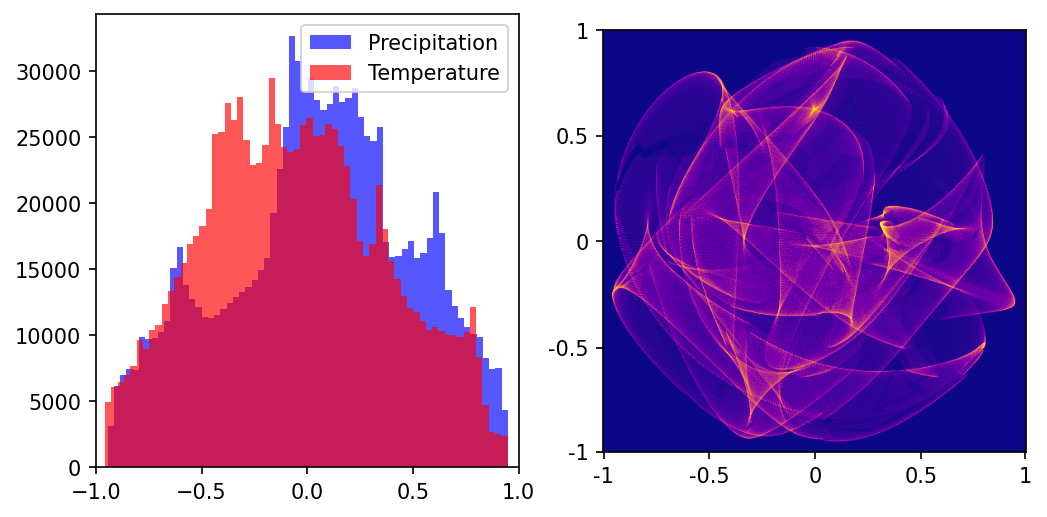

In [266]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].hist(temperature_map.flatten(), bins=64, color="blue", alpha=0.66, label="Precipitation")
axes[0].hist(precipitation_map.flatten(), bins=64, color="red", alpha=0.66, label="Temperature")
axes[0].set_xlim(-1, 1)
axes[0].legend()

hist2d = np.histogram2d(
    temperature_map.flatten(), precipitation_map.flatten(),
    bins=(512, 512), range=((-1, 1), (-1, 1))
)[0]

from scipy.special import expit
hist2d = np.interp(hist2d, (hist2d.min(), hist2d.max()), (0, 1))
hist2d = expit(hist2d/0.1)

axes[1].imshow(hist2d, cmap="plasma")

axes[1].set_xticks([0, 128, 256, 385, 511])
axes[1].set_xticklabels([-1, -0.5, 0, 0.5, 1])
axes[1].set_yticks([0, 128, 256, 385, 511])
axes[1].set_yticklabels([1, 0.5, 0, -0.5, -1])

In [267]:
from skimage import exposure

def histeq(img,  alpha=1):
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    img_eq = np.interp(img, bin_centers, img_cdf)
    img_eq = np.interp(img_eq, (0, 1), (-1, 1))
    return alpha * img_eq + (1 - alpha) * img

In [268]:
uniform_temperature_map = histeq(temperature_map, alpha=0.33)
uniform_precipitation_map = histeq(precipitation_map, alpha=0.33)

[Text(0, 0, '1'),
 Text(0, 128, '0.5'),
 Text(0, 256, '0'),
 Text(0, 385, '-0.5'),
 Text(0, 511, '-1')]

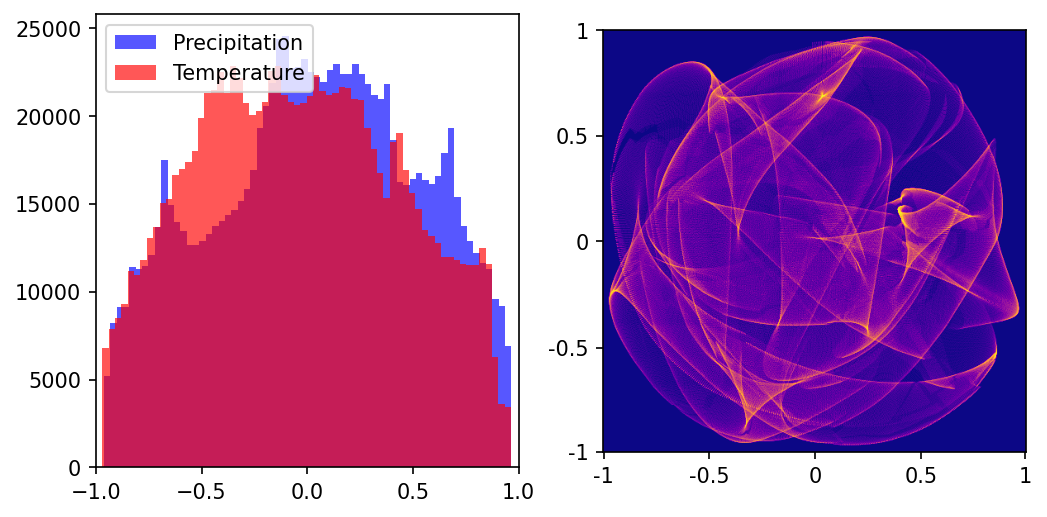

In [269]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].hist(uniform_temperature_map.flatten(), bins=64, color="blue", alpha=0.66, label="Precipitation")
axes[0].hist(uniform_precipitation_map.flatten(), bins=64, color="red", alpha=0.66, label="Temperature")
axes[0].set_xlim(-1, 1)
axes[0].legend()

hist2d = np.histogram2d(
    uniform_temperature_map.flatten(), uniform_precipitation_map.flatten(),
    bins=(512, 512), range=((-1, 1), (-1, 1))
)[0]

from scipy.special import expit
hist2d = np.interp(hist2d, (hist2d.min(), hist2d.max()), (0, 1))
hist2d = expit(hist2d/0.1)

axes[1].imshow(hist2d, cmap="plasma")

axes[1].set_xticks([0, 128, 256, 385, 511])
axes[1].set_xticklabels([-1, -0.5, 0, 0.5, 1])
axes[1].set_yticks([0, 128, 256, 385, 511])
axes[1].set_yticklabels([1, 0.5, 0, -0.5, -1])

In [270]:
temperature_map = uniform_temperature_map
precipitation_map = uniform_precipitation_map

## Averaging Cells

In [271]:
def average_cells(vor, data):
    """Returns the average value of data inside every voronoi cell"""
    size = vor.shape[0]
    count = np.max(vor)+1

    sum_ = np.zeros(count)
    count = np.zeros(count)

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            count[p] += 1
            sum_[p] += data[i, j]

    average = sum_/count
    average[count==0] = 0

    return average

def fill_cells(vor, data):
    size = vor.shape[0]
    image = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            image[i, j] = data[p]

    return image

def color_cells(vor, data, dtype=int):
    size = vor.shape[0]
    image = np.zeros((size, size, 3))

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            image[i, j] = data[p]

    return image.astype(dtype)

In [272]:
temperature_cells = average_cells(vor_map, temperature_map)
precipitation_cells = average_cells(vor_map, precipitation_map)

temperature_map = fill_cells(vor_map, temperature_cells)
precipitation_map = fill_cells(vor_map, precipitation_cells)

<ipython-input-271-ae190c45367b>:15: RuntimeWarning: invalid value encountered in true_divide
  average = sum_/count


Text(0.5, 1.0, 'Precipitation')

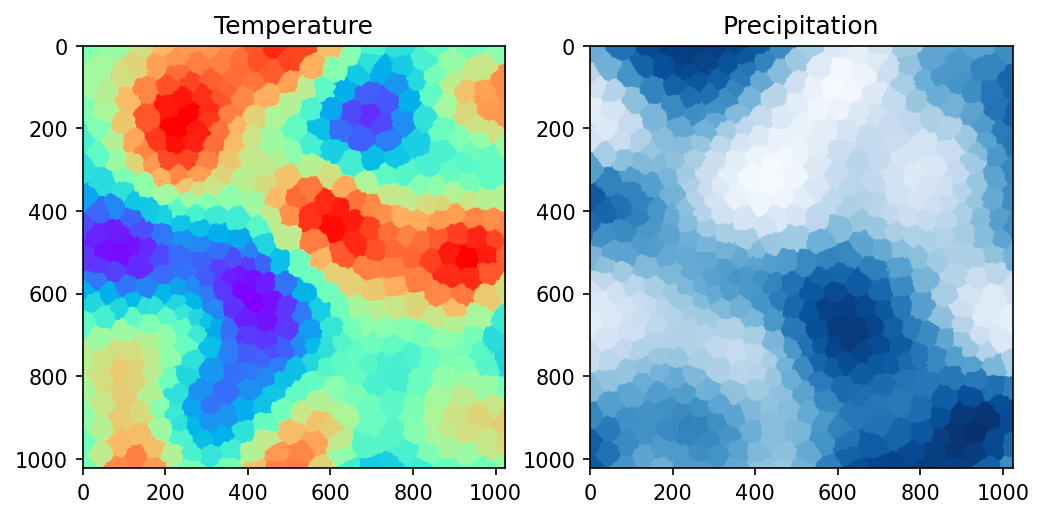

In [273]:
fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

ax[0].imshow(temperature_map, cmap="rainbow")
ax[0].set_title("Temperature")

ax[1].imshow(precipitation_map, cmap="Blues")
ax[1].set_title("Precipitation")

## Quantization

In [274]:
def quantize(data, n):
    bins = np.linspace(-1, 1, n+1)
    return (np.digitize(data, bins) - 1).clip(0, n-1)

n = 256

quantize_temperature_cells = quantize(temperature_cells, n)
quantize_precipitation_cells = quantize(precipitation_cells, n)

quantize_temperature_map = fill_cells(vor_map, quantize_temperature_cells)
quantize_precipitation_map = fill_cells(vor_map, quantize_precipitation_cells)

In [275]:
temperature_cells = quantize_temperature_cells
precipitation_cells = quantize_precipitation_cells

temperature_map = quantize_temperature_map
precipitation_map = quantize_precipitation_map

## Temperature–Precipitation graph

In [276]:
im = np.array(Image.open("output/TP_map.png"))[:, :, :3]
biomes = np.zeros((256, 256))

biome_names = [
  "desert",
  "savanna",
  "tropical_woodland",
  "tundra",
  "seasonal_forest",
  "rainforest",
  "temperate_forest",
  "temperate_rainforest",
  "boreal_forest"
]
biome_colors = [
  [255, 255, 178],
  [184, 200, 98],
  [188, 161, 53],
  [190, 255, 242],
  [106, 144, 38],
  [33, 77, 41],
  [86, 179, 106],
  [34, 61, 53],
  [35, 114, 94]
]

for i, color in enumerate(biome_colors):
    indices = np.where(np.all(im == color, axis=-1))
    biomes[indices] = i
    
biomes = np.flip(biomes, axis=0).T

Text(0.5, 1.0, 'Temperature–Precipitation graph')

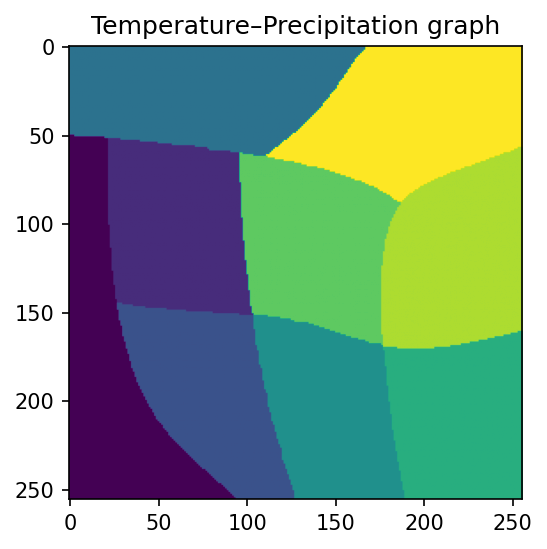

In [277]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.imshow(biomes)
plt.title("Temperature–Precipitation graph")

## Biome map

In [278]:
n = len(temperature_cells)
biome_cells = np.zeros(n, dtype=np.uint32)

for i in range(n):
    temp, precip = temperature_cells[i], precipitation_cells[i]
    biome_cells[i] = biomes[temp, precip]
    
biome_map = fill_cells(vor_map, biome_cells).astype(np.uint32)
biome_color_map = color_cells(biome_map, biome_colors)

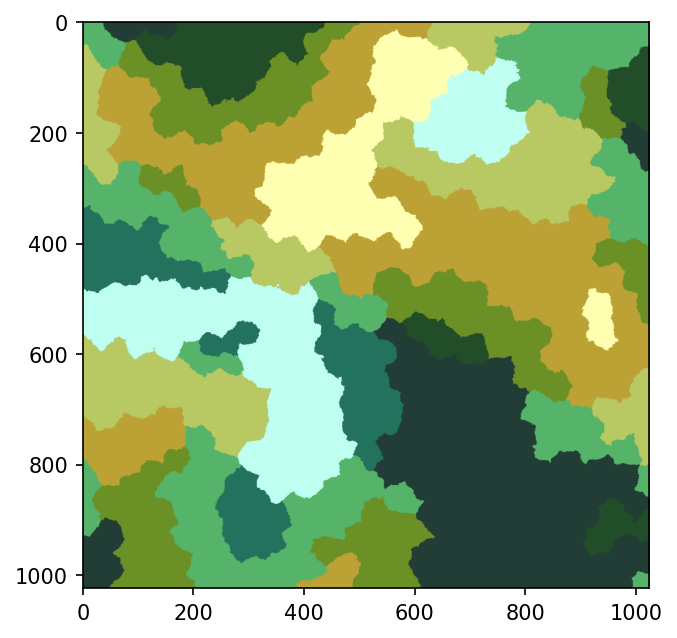

In [279]:
fig = plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(biome_color_map)

# Height Map

In [280]:
height_map = noise_map(size, 4, 0, octaves=6, persistence=0.5, lacunarity=2)
land_mask = height_map > 0

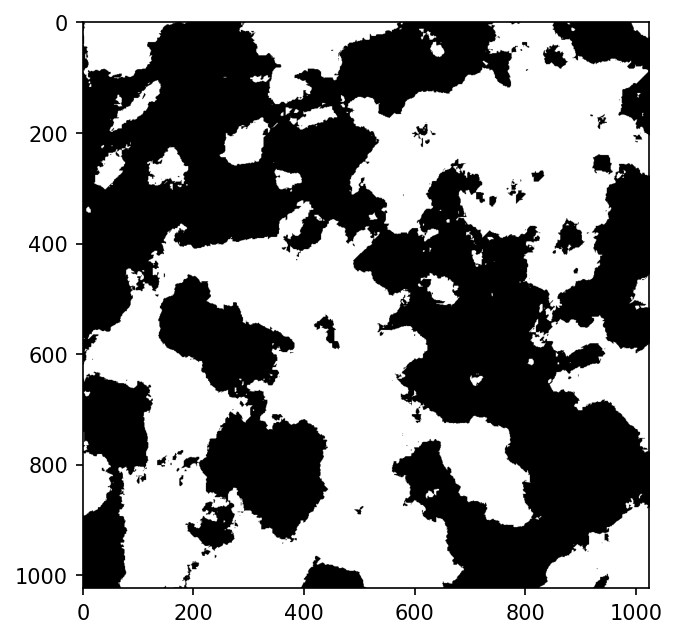

In [281]:
fig = plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(land_mask, cmap='gray')

In [282]:
sea_color = np.array([12, 14, 255])
land_mask_color = np.repeat(land_mask[:, :, np.newaxis], 3, axis=-1)
masked_biome_color_map = land_mask_color*biome_color_map + (1-land_mask_color)*sea_color

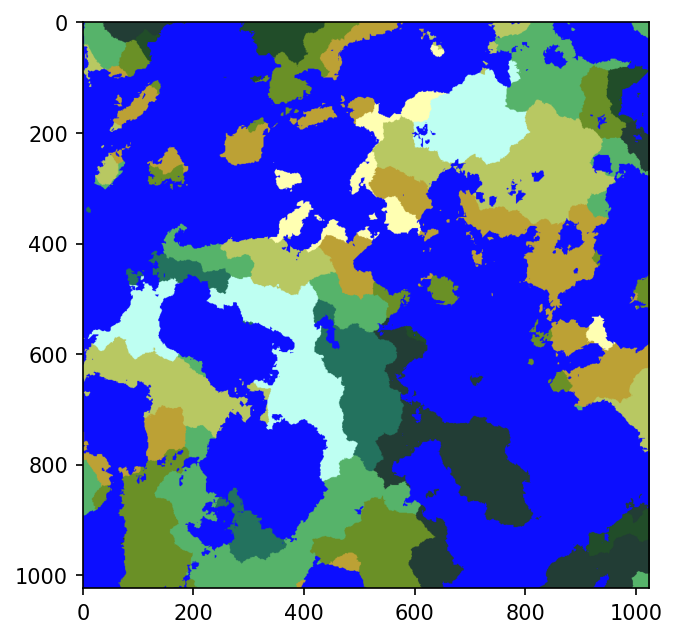

In [283]:
fig = plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(masked_biome_color_map)

In [248]:
# https://github.com/Mehdi-Antoine/NormalMapGenerator

from scipy import ndimage

def gradient(im_smooth):
    gradient_x = im_smooth.astype(float)
    gradient_y = im_smooth.astype(float)

    kernel = np.arange(-1,2).astype(float)
    kernel = - kernel / 2

    gradient_x = ndimage.convolve(gradient_x, kernel[np.newaxis])
    gradient_y = ndimage.convolve(gradient_y, kernel[np.newaxis].T)

    return gradient_x, gradient_y

def sobel(im_smooth):
    gradient_x = im_smooth.astype(float)
    gradient_y = im_smooth.astype(float)

    kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

    gradient_x = ndimage.convolve(gradient_x, kernel)
    gradient_y = ndimage.convolve(gradient_y, kernel.T)

    return gradient_x, gradient_y

def compute_normal_map(gradient_x, gradient_y, intensity=1):
    width = gradient_x.shape[1]
    height = gradient_x.shape[0]
    max_x = np.max(gradient_x)
    max_y = np.max(gradient_y)

    max_value = max_x

    if max_y > max_x:
        max_value = max_y

    normal_map = np.zeros((height, width, 3), dtype=np.float32)

    intensity = 1 / intensity

    strength = max_value / (max_value * intensity)

    normal_map[..., 0] = gradient_x / max_value
    normal_map[..., 1] = gradient_y / max_value
    normal_map[..., 2] = 1 / strength

    norm = np.sqrt(np.power(normal_map[..., 0], 2) + np.power(normal_map[..., 1], 2) + np.power(normal_map[..., 2], 2))

    normal_map[..., 0] /= norm
    normal_map[..., 1] /= norm
    normal_map[..., 2] /= norm

    normal_map *= 0.5
    normal_map += 0.5

    return normal_map


def get_normal_map(im, intensity=1.0):
    sobel_x, sobel_y = sobel(im)
    normal_map = compute_normal_map(sobel_x, sobel_y, intensity)
    return normal_map

def get_normal_light(height_map_):
    normal_map_ = get_normal_map(height_map_)[:,:,0:2].mean(axis=2)
    normal_map_ = np.interp(normal_map_, (0, 1), (-1, 1))
    return normal_map_

def apply_height_map(im_map, smooth_map, height_map, land_mask):
    normal_map = get_normal_light(height_map)
    normal_map =  normal_map*land_mask + smooth_map/2*(~land_mask)

    normal_map = np.interp(normal_map, (-1, 1), (-192, 192))

    normal_map_color = np.repeat(normal_map[:, :, np.newaxis], 3, axis=-1)
    normal_map_color = normal_map_color.astype(int)

    out_map = im_map + normal_map_color
    return out_map, normal_map

In [249]:
biome_height_map, normal_map = apply_height_map(masked_biome_color_map, height_map, height_map, land_mask)

fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(10, 5)

ax[0].imshow(masked_biome_color_map)
ax[0].set_title("Biomes")

ax[1].imshow(biome_height_map)
ax[1].set_title("Biomes with normal")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Biomes with normal')

Error in callback <function flush_figures at 0x00000142D1712B80> (for post_execute):


KeyboardInterrupt: 

## Height Map Detail

In [250]:
height_map = noise_map(size, 4, 0, octaves=6, persistence=0.5, lacunarity=2)
smooth_height_map = noise_map(size, 4, 0, octaves=1, persistence=0.5, lacunarity=2)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(10, 5)

ax[0].imshow(height_map, cmap="gray")
ax[0].set_title("Height Map")

ax[1].imshow(smooth_height_map, cmap="gray")
ax[1].set_title("Smooth Height Map")

## Height Map Filters

### Bézier Curves

In [ ]:
def bezier(x1, y1, x2, y2, a):
    p1 = np.array([0, 0])
    p2 = np.array([x1, y1])
    p3 = np.array([x2, y2])
    p4 = np.array([1, a])

    return lambda t: ((1-t)**3 * p1 + 3*(1-t)**2*t * p2 + 3*(1-t)*t**2 * p3 + t**3 * p4)

In [ ]:
from scipy.interpolate import interp1d

def bezier_lut(x1, y1, x2, y2, a):
    t = np.linspace(0, 1, 256)
    f = bezier(x1, y1, x2, y2, a)
    curve = np.array([f(t_) for t_ in t])

    return interp1d(*curve.T)

def filter_map(h_map, smooth_h_map, x1, y1, x2, y2, a, b):
    f = bezier_lut(x1, y1, x2, y2, a)
    output_map = b*h_map + (1-b)*smooth_h_map
    output_map = f(output_map.clip(0, 1))
    return output_map

In [ ]:
# f = bezier_lut(0.8, 0.1, 0.9, 0.05, 0.05)
# t = np.linspace(0, 1, 1000)
# y = f(t)

# from matplotlib.gridspec import GridSpec

# fig = plt.figure(dpi=120, figsize=(8, 8/3))
# gs = GridSpec(1, 3)

# ax1 = plt.subplot(gs[:,:1])
# ax1.plot(t, y)
# ax1.set_xlim(0, 1)
# ax1.set_ylim(0, 1)
# ax1.set_title("Boreal Filter")

# ax2 = plt.subplot(gs[:,1:])
# ax2.plot(height_map[100].clip(0, 1))
# ax2.plot(boreal_map[100])
# ax2.set_ylim(0, 1)
# ax2.set_title("Example")

# plt.savefig("figures/figure_13/9.jpg")

### Filters

In [ ]:
biome_height_maps = [
    # Desert
    filter_map(height_map, smooth_height_map, 0.75, 0.2, 0.95, 0.2, 0.2, 0.5),
    # Savanna
    filter_map(height_map, smooth_height_map, 0.5, 0.1, 0.95, 0.1, 0.1, 0.2),
    # Tropical Woodland
    filter_map(height_map, smooth_height_map, 0.33, 0.33, 0.95, 0.1, 0.1, 0.75),
    # Tundra
    filter_map(height_map, smooth_height_map, 0.5, 1, 0.25, 1, 1, 1),
    # Seasonal Forest
    filter_map(height_map, smooth_height_map, 0.75, 0.5, 0.4, 0.4, 0.33, 0.2),
    # Rainforest
    filter_map(height_map, smooth_height_map, 0.5, 0.25, 0.66, 1, 1, 0.5),
    # Temperate forest
    filter_map(height_map, smooth_height_map, 0.75, 0.5, 0.4, 0.4, 0.33, 0.33),
    # Temperate Rainforest
    filter_map(height_map, smooth_height_map, 0.75, 0.5, 0.4, 0.4, 0.33, 0.33),
    # Boreal
    filter_map(height_map, smooth_height_map, 0.8, 0.1, 0.9, 0.05, 0.05, 0.1)
]

### Biome masks

In [ ]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation

biome_count = len(biome_names)
biome_masks = np.zeros((biome_count, size, size))

for i in range(biome_count):
    biome_masks[i, biome_map==i] = 1
    biome_masks[i] = gaussian_filter(biome_masks[i], sigma=16)

# Remove ocean from masks
blurred_land_mask = land_mask
blurred_land_mask = binary_dilation(land_mask, iterations=32).astype(np.float64)
blurred_land_mask = gaussian_filter(blurred_land_mask, sigma=16)

biome_masks = biome_masks*blurred_land_mask

In [ ]:
plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(biome_masks[6], cmap="gray")

### Applying Filters

In [ ]:
adjusted_height_map = height_map.copy()

for i in range(len(biome_height_maps)):
    adjusted_height_map = (1-biome_masks[i])*adjusted_height_map + biome_masks[i]*biome_height_maps[i]

In [ ]:
biome_height_map = apply_height_map(masked_biome_color_map, height_map, height_map, land_mask)
new_biome_height_map = apply_height_map(masked_biome_color_map, adjusted_height_map, adjusted_height_map, land_mask)

fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(10, 5)

ax[0].imshow(adjusted_height_map)
ax[0].set_title("Before")

ax[1].imshow(new_biome_height_map[0])
ax[1].set_title("After")

# Rivers

## Boundaries

In [ ]:
def get_boundary(vor_map, kernel=1):
    boundary_map = np.zeros_like(vor_map, dtype=bool)
    n, m = vor_map.shape
    
    clip = lambda x: max(0, min(size-1, x))
    def check_for_mult(a):
        b = a[0]
        for i in range(len(a)-1):
            if a[i] != b: return 1
        return 0
    
    for i in range(n):
        for j in range(m):
            boundary_map[i, j] = check_for_mult(vor_map[
                clip(i-kernel):clip(i+kernel+1),
                clip(j-kernel):clip(j+kernel+1),
            ].flatten())
            
    return boundary_map

In [ ]:
biome_bound = get_boundary(biome_map, kernel=5)
cell_bound = get_boundary(vor_map, kernel=2)

In [ ]:
river_mask = noise_map(size, 4, 4353, octaves=6, persistence=0.5, lacunarity=2) > 0

new_biome_bound = biome_bound*(adjusted_height_map<0.5)*land_mask
new_cell_bound = cell_bound*(adjusted_height_map<0.05)*land_mask

rivers = np.logical_or(new_biome_bound, new_cell_bound)*river_mask

In [ ]:
loose_river_mask = binary_dilation(rivers, iterations=8)
rivers_height = gaussian_filter(rivers.astype(np.float64), sigma=2)*loose_river_mask

In [ ]:
adjusted_height_river_map = adjusted_height_map*(1-rivers_height) - 0.05*rivers

In [ ]:
river_land_mask = adjusted_height_river_map >= 0
land_mask_color = np.repeat(river_land_mask[:, :, np.newaxis], 3, axis=-1)
rivers_biome_color_map = land_mask_color*biome_color_map + (1-land_mask_color)*sea_color

plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(rivers_biome_color_map)

In [ ]:
# color_map = apply_height_map(rivers_biome_color_map, adjusted_height_river_map, adjusted_height_river_map, river_land_mask)
# plt.imshow(color_map[0])

# im = Image.fromarray(color_map[0].clip(0, 255).astype(np.uint8))
# im.save("figures/10.png")

# Trees and Vegetation

In [ ]:
def filter_inbox(pts):
    inidx = np.all(pts < size, axis=1)
    return pts[inidx]

def generate_trees(n):
    trees = np.random.randint(0, size-1, (n, 2))
    trees = relax(trees, size, k=10).astype(np.uint32)
    trees = filter_inbox(trees)
    return trees

In [ ]:
# Example
low_density_trees = generate_trees(1000)
medium_density_trees = generate_trees(5000)
high_density_trees = generate_trees(25000)

In [ ]:
plt.figure(dpi=150, figsize=(10, 3))
plt.subplot(131)
plt.scatter(*low_density_trees.T, s=1)
plt.title("Low Density Trees")
plt.xlim(0, 256)
plt.ylim(0, 256)

plt.subplot(132)
plt.scatter(*medium_density_trees.T, s=1)
plt.title("Medium Density Trees")
plt.xlim(0, 256)
plt.ylim(0, 256)

plt.subplot(133)
plt.scatter(*high_density_trees.T, s=1)
plt.title("High Density Trees")
plt.xlim(0, 256)
plt.ylim(0, 256)

In [ ]:
def place_trees(n, mask, a=0.5):
    trees= generate_trees(n)
    rr, cc = trees.T

    output_trees = np.zeros((size, size), dtype=bool)
    output_trees[rr, cc] = True
    output_trees = output_trees*(mask>a)*river_land_mask*(adjusted_height_river_map<0.5)

    output_trees = np.array(np.where(output_trees == 1))[::-1].T    
    return output_trees

In [ ]:
tree_densities = [4000, 1500, 8000, 1000, 10000, 25000, 10000, 20000, 5000]
trees = [np.array(place_trees(tree_densities[i], biome_masks[i]))
         for i in range(len(biome_names))]

In [ ]:
color_map = apply_height_map(rivers_biome_color_map, adjusted_height_river_map, adjusted_height_river_map, river_land_mask)

plt.figure(dpi=150, figsize=(5, 5))
for k in range(len(biome_names)):
    plt.scatter(*trees[k].T, s=0.15, c="red")

plt.imshow(color_map[0])